**Name Surname**   : Mohamed Yahya Mansouri

---


# **Data Prepocessing and Regression**

---
**Dataset Path:** "Data/insurance.csv"
---

We will deal with the insurance dataset. This dataset contains data on individual medical insurance costs based on several demographic and personal health factors.

**Features:**


* Age: Age of the individual
* Sex: Gender of the individual
* BMI: Body Mass Index, a measure of body fat based on height and weight
* Children: Number of children/dependents
* Smoker: Whether the individual smokes or not
* Region: Geographical region in the US
* Charges: Medical expenses (target variable for regression)

# **Necessary Imports**

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sn
from IPython.display import HTML
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# **Necessary Functions**

In [ ]:
#Function to visualize data
#datafarme: The dataframe containing the data
#features: The features of the data to be visualzed
#type: The type of the graph to be used
#figure_size: The size of the pyplot graph
#n_cols: The number of columns, as the function visualizes using subplots only
def visualize(dataframe, features, type, figure_size, n_cols):
    target = "charges"
    n_features = len(features)
    n_rows = (n_features + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows,n_cols, figsize=figure_size)
    axes = axes.flatten()
    for index, feature in enumerate(features):
        ax = axes[index]
        if(type == "hist"):
            ax.hist(dataframe[feature], bins=20, alpha=0.8, edgecolor="black", color="red")
        elif(type == "boxplot_both"):
            sn.boxplot(x=feature, y=target, data=dataframe, ax=ax)
        elif(type == "boxplot"):
            sn.boxplot(data=dataframe[feature], ax = ax)
        elif(type == "scatter"):
            ax.scatter(dataframe[feature], dataframe[target], alpha=0.5)
        ax.set_title(feature)
        ax.set_xlabel("Values")
        ax.set_ylabel("Frequency")
    
    if(n_features % 2 != 0 and n_cols % 2 == 0): #to remove any empty unsued graph
        fig.delaxes(axes[n_features])
    plt.subplots_adjust(wspace=0.3, hspace=0.5)
    plt.show()

#Calculte the outer or inner fences for outlier identification
#dataframe: The dataframe to be used
#feature: The specific feature to look up the outliers
#coef: The coefficient to specify the type of the fence; 1.5 for inner fences and 3 for outer fences
#return:  The lower and upper values of the fences in a list
def calculate_fence(dataframe, feature, coef):
    Q1 = dataframe[feature].quantile(0.25)
    Q3 = dataframe[feature].quantile(0.75)
    IQR = Q3 - Q1
    fences = [Q1 - coef*IQR, Q3 + coef*IQR]
    return fences

#Prints some text in a specified style using HTML
#text: The content to be printed
def print_style(text):
    display(HTML(f'''
        <p style="text-align:center;margin:0;">---------------------------------------------------</p>
        <p style="text-align:center;text-transform:capitalize; margin:0;">{text}</p>
        <p style="text-align:center;margin:0;">----------------------------------------------------</p>
    '''))

#Encodes oridnal variables. Not a very dynamic function, only used for this project.
#dataframe: The dataframe to be used for encoding
#feature: The feature to be encoded.
#return: Returns the dataframe with the encoded feature
def encode_ordinal(dataframe, feature):
    dataframe.loc[dataframe[feature] == "yes", feature] = 1 
    dataframe.loc[dataframe[feature] == "no", feature] = 0
    return dataframe

#Calculates the R² score
#y: are the original target values
#y_pred: are the predicted target values by a model
#return: returns the R²
def r_squared(y, y_pred):
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared


# **PART- 1: Data Preprocessing**

---

## 1.1. Explaratory Data Analysis

* Checked for missing values
* Visualized the features with any relevant plots to understand the distribution of data
* Visualized the target variable with respect to the features
* Visualized the correlation between the features using a heatmap
* Report

<b>Note</b>: 
- Some blocks will have comments but everything will be discussed in details in the report at the end of each section.

In [3]:
# your code here
df = pd.read_csv("data/insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
### missing values - NO MISSING VALUES
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [5]:
print("Number of duplicates: ", df.duplicated().sum())
#df_no_duplicates = df.drop_duplicates()
df[df.duplicated()]

Number of duplicates:  1


,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.5631


<b>Note</b>: 
- We have duplicates.
- There are duplicates in our dataset. Since we only have one duplicate, I will continue with keeping it. It turned out that removing it hindered the R² results of the models.

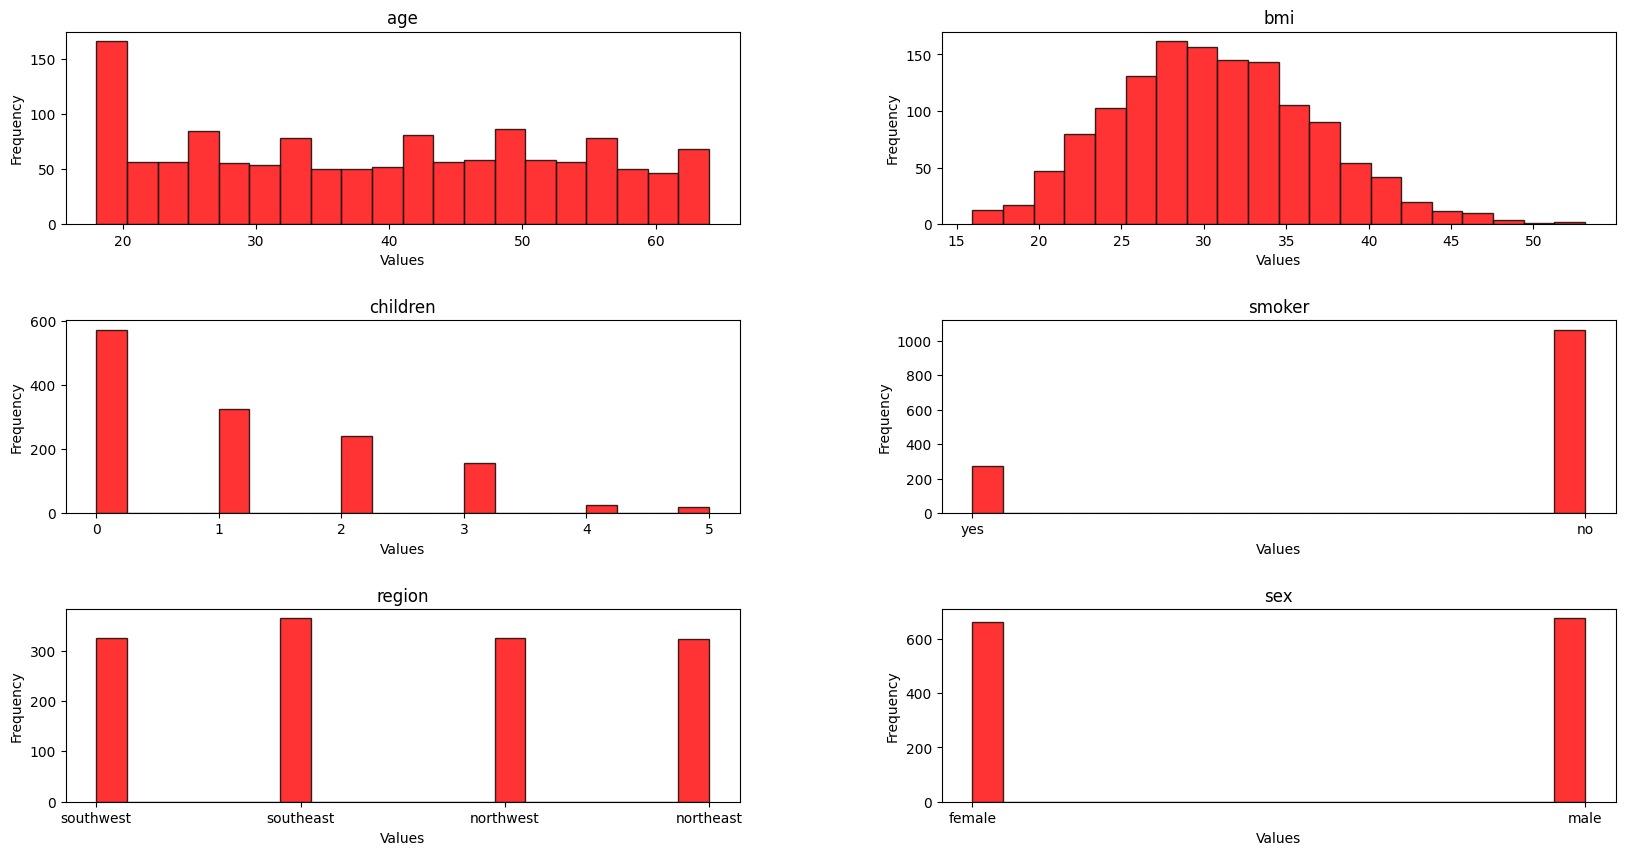

In [6]:
visualize(df, ["age","bmi","children","smoker","region","sex"], "hist", (20,10), 2)
#visualize features -- positively skewed to the right. there can be outliers in the age feature for very young ages
#little positively skewed. there can be some outliers at very high values of BMI
#Children: positively skewed as well
#not sth special -- region may not a big factor in predicting our target value, to be verified.
#Children is treated as categorical variable. It has a very finite number of values.

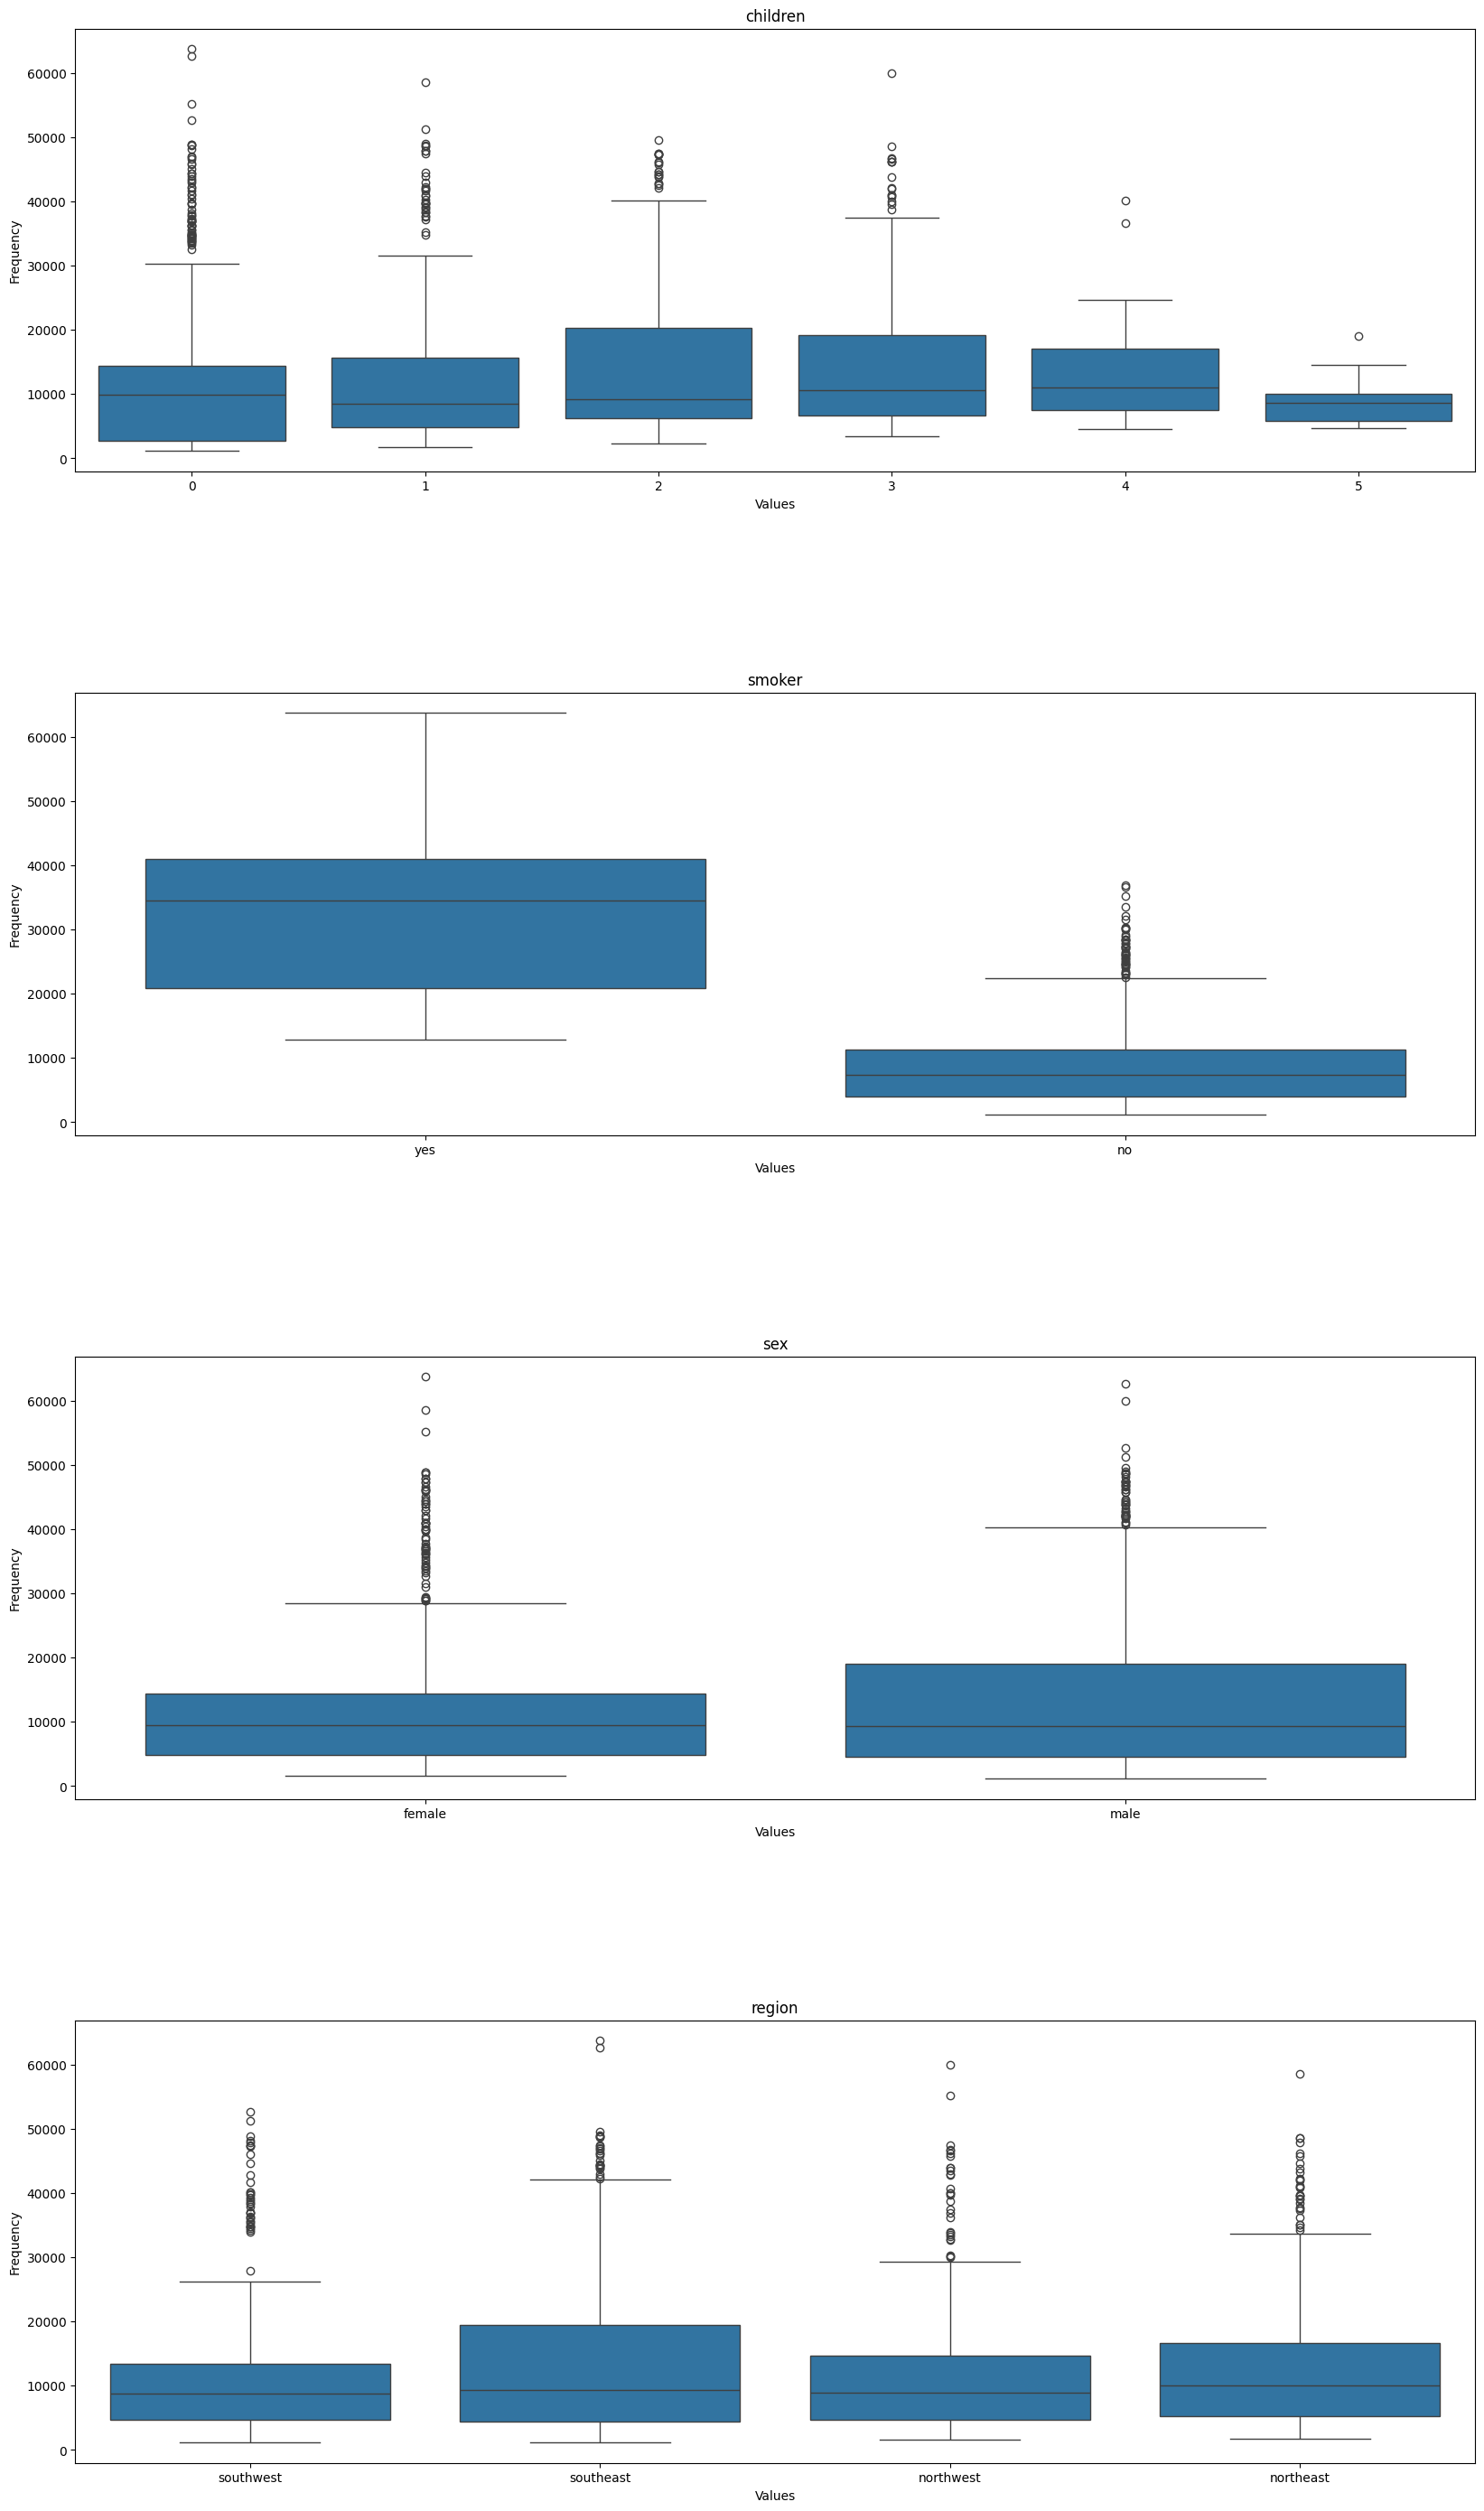

In [7]:
#Target variable visualization with respect to categorical features
categorical_features = ["children","smoker","sex", "region"]
visualize(df, categorical_features, "boxplot_both", (20,35), 1)
##According to these boxplots we have noticed a high number of outliers

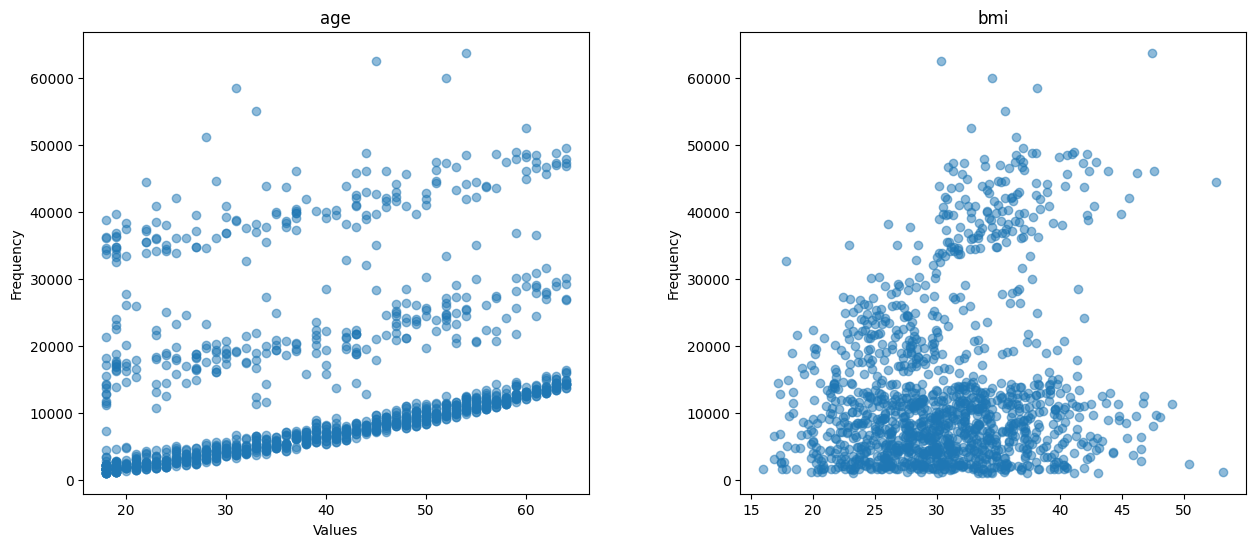

In [8]:
#Target variable visualization  with respect to numerical features
numerical_features = ["age", "bmi"]
visualize(df, numerical_features, "scatter", (15,6), 2)

## Data Analysis Visualization Report:
- The histograms of numerical variables and bar plots of categorical variables verify that the features are <b>positively skewed</b>. We can anticipate to have some outliers in these following features: bmi, age, children, and smoker.<br />
The frequencies of the region values are uniformly distributed. The distribution of charges in the boxplot of <i>region vs charges</i> does not differ significanlty, suggesting a low correlation between the categorical variable <i>region</i> and the target variable<br />
The frequencies of the <i>sex</i> values are very close to each other. This can be a potential clue of the correlation between <i>sex</i> and the target value.
- The boxplots depicting the relationship betwene cateogircal variables and the target variables also suggests that:
  <ol>
      <li>the values are <b>positively skewed with a long tail extending to the right</b> (<u>which is the top in the graph</u>)</li>
      <li>The median of the <i>children values</i> and the <i>sex</i> values are very close to their unique values.</li>
      <li><b>Not much of a variance in the </b> <i>children vs charges</i> and <i>region vs charges</i> boxplots.</li>
      <li>The similarities in the boxplots of the unique values in relation to the target variable can suggest a low direct relationship</li>
      <li>Some outliers -- <i>to be dealt with.</i></li>
      <li>For the smoker feature, the median is very different with the "yes" value. "Yes" frequencies are drastically higher than "no" frequencies. This suggests a <b>higher positive correlation and relationship</b> between the target variable and the smoker feature. Meaning, smokers have high insurance charges than non-smokers</li>
      <li>The boxplots for the <i>sex vs charges</i> exhibit similar IQR and medians. This indicates that the value dispersion and variance are kind of consistent. Which in return indicates a low to no correlation in sex and the target variable. We can dequeue it from the dataframe later on in the model phase</li>
  </ol>
- For the visualization of the relationship between the target variables and two variables <i>age</i> and <i>bmi</i> we notice:
  <ol>
      <li>A positive correlation between age and charges. We see a positive increase in the age along with an increase in the charges. Old people have high insurance charges.<br />
          Despite seeing some outliers in the graph we notice a hugely higher concentration in the linear trend. We also notice that the data points are divided in 3 different clusters. This can help us decide on the optimal k number later on.</li>
      <li>We can't infer much of a correlation between bmi and charges. The data dots are very dispersed. So low or high body mass index values cannot much indicate a high or low insurance charges.</li>
  </ol>

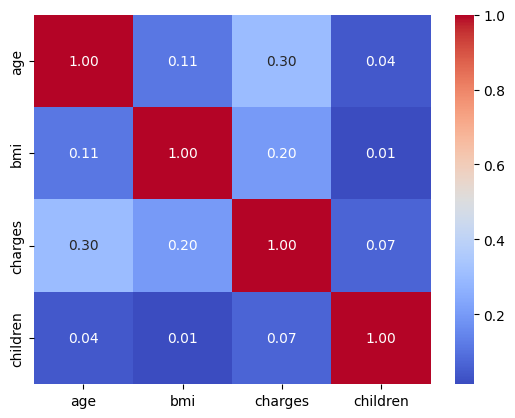

In [9]:
#CORRELATION - HEATMAP
df_heatmap = df[["age","bmi","charges","children"]].corr()
sn.heatmap(df_heatmap, cmap='coolwarm', annot=True, fmt='.2f')
plt.show()

## HeatMap Analysis Report:
As anticipated before, we can confirm that:
- The target variable and <i>age</i> has the highest positive correlation
- The target variable and <i>bmi</i> has a moderate positive correlation that should be considered
- The target variable and <i>children</i> has a low positive correlation.

It will be beneficial to deal with the outliers and then check the correlations again.

In [10]:
#Dropping unecessary features
df = df.drop(["sex","region"], axis=1)

## 1.2. Outlier Detection

#### 1.2.1 Numerical Variables (with children) Outlier Detection

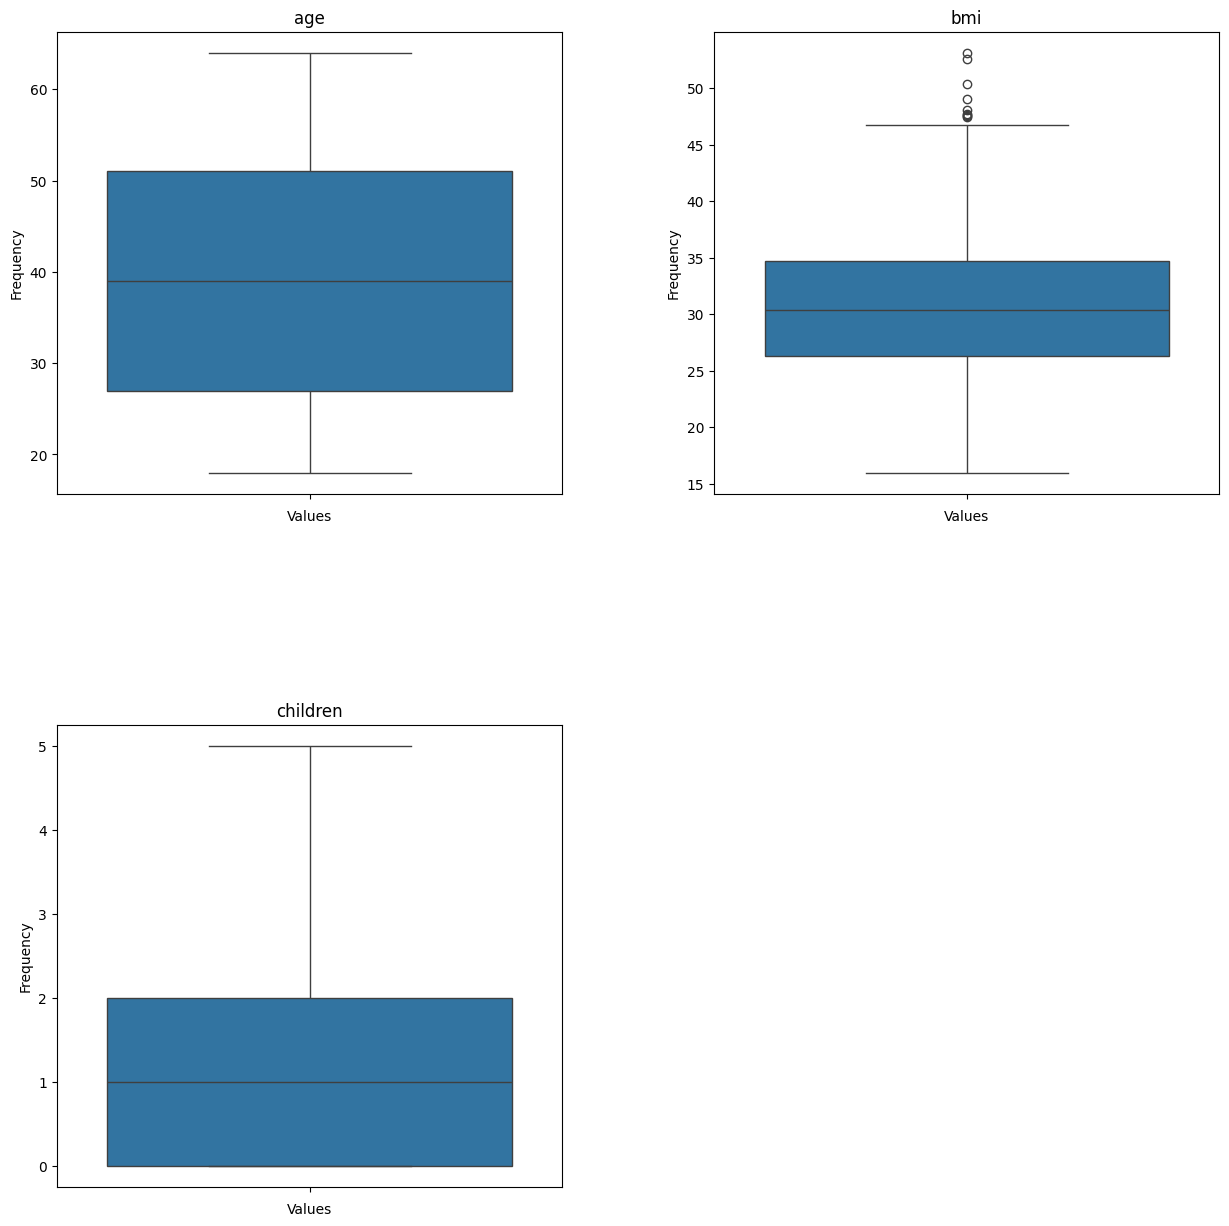

In [11]:
# your code here
features = ["age","bmi","children"]
visualize(df, features, "boxplot", (15,15), 2)

In [12]:
#Deeper Outlier Detection for numerical data
numerical_features = ["age", "bmi"]
for feature in numerical_features:
    inner_fences = calculate_fence(df, feature, 1.5)
    outer_fences = calculate_fence(df, feature, 3)
    print("Printing the outliers of", feature, '\n')
    print("The following outliers are mild outliers")
    print(df[(df[feature] < inner_fences[0]) | (df[feature] > inner_fences[1])], '\n')
    print("The following outliers are extreme outliers")
    print(df[(df[feature] < outer_fences[0]) | (df[feature] > outer_fences[1])])
    print("\n------------------------------------")
    print("------------------------------------")
    print("------------------------------------\n")
    

Printing the outliers of age 

The following outliers are mild outliers
Empty DataFrame
Columns: [age, bmi, children, smoker, charges]
Index: [] 

The following outliers are extreme outliers
Empty DataFrame
Columns: [age, bmi, children, smoker, charges]
Index: []

------------------------------------
------------------------------------
------------------------------------

Printing the outliers of bmi 

The following outliers are mild outliers
      age    bmi  children smoker      charges
116    58  49.06         0     no  11381.32540
286    46  48.07         2     no   9432.92530
401    47  47.52         1     no   8083.91980
543    54  47.41         0    yes  63770.42801
847    23  50.38         1     no   2438.05520
860    37  47.60         2    yes  46113.51100
1047   22  52.58         1    yes  44501.39820
1088   52  47.74         1     no   9748.91060
1317   18  53.13         0     no   1163.46270 

The following outliers are extreme outliers
Empty DataFrame
Columns: [age, bmi,

#### Numerical Variables Outlier Detection Report
I decided to go with statistical methods to identify outliers. It was suitable to start with boxplots to detect outliers for every variable, especially for categorical variables: sex, smoker, children. To dig deeper, I decided to implement the IQR outlier detection method to detect both mild and extreme outliers.
Findings:
- The boxplot and the IQR method both confirm that age does not have any outliers
- While the boxplot successively detected the outliers in bmi, IQR classified them only as mild outliers.

#### 1.2.2 Categorical Variables Outlier Detection

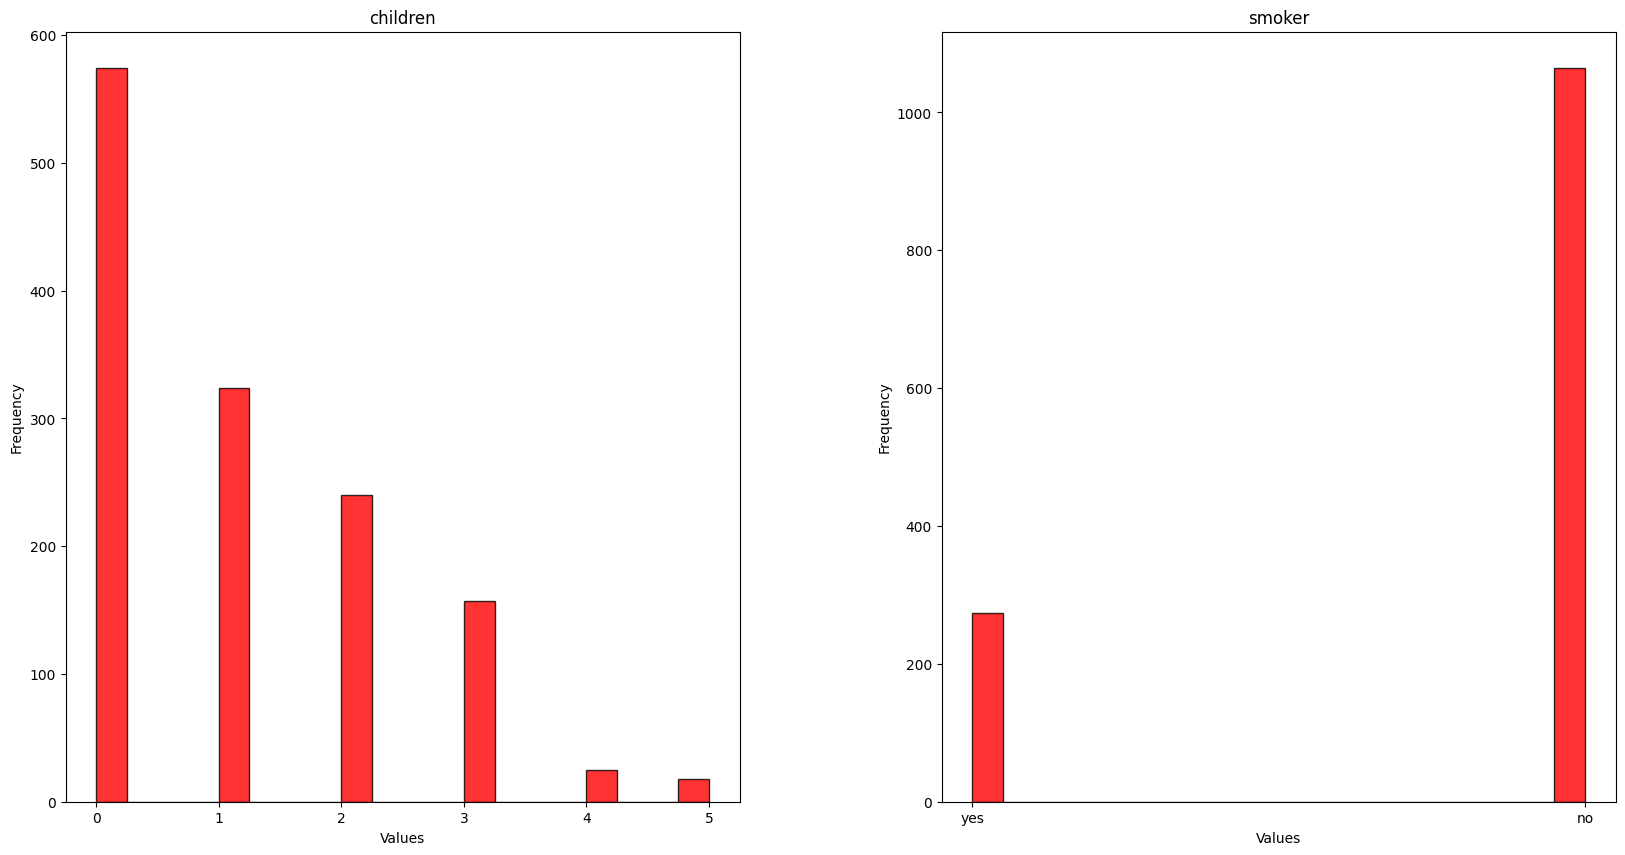

In [13]:
visualize(df, ["children","smoker"], "hist", (20,10), 2)

In [14]:
four_year_old = df["children"][df["children"] == 4].count()
five_year_old = df["children"][df["children"] == 5].count()
total = four_year_old + five_year_old
print("Count of individuals with 4-year-old children: ",four_year_old)
print("Count of individuals with 5-year-old children: ",five_year_old)
print("Total: ", total)

Count of individuals with 4-year-old children:  25
Count of individuals with 5-year-old children:  18
Total:  43


In [15]:
#The treshold value that identifies the outliers int the children categorical variable
threshold = 26

- children feature: we see that the last two values are the outliers with 25 frequency for individuals with 4 children and 18 frequency for individuals with 5 children. <b>25 can be our threshold to identify the rows with the outliers.</b>
- Rest of categorical features: no outliers

## 1.3. Outlier Handling
Methods used to handle outliers: Mean Imputation - Median Imputation

#### Outlier Removal Method

In [16]:
inner_fence = calculate_fence(df, "bmi", 1.5)
frequency_counts = df["children"].value_counts()
frequency_counts = frequency_counts[frequency_counts >= threshold].index
df_removed_outliers = df[(df["bmi"] >= inner_fence[0]) & (df["bmi"] <= inner_fence[1]) & (df["children"].isin(frequency_counts))]
print("new: ", df_removed_outliers.shape, "\nold: ", df.shape)
print("Total number of outliers: ", df.shape[0] - df_removed_outliers.shape[0])

new:  (1286, 5) 
old:  (1338, 5)
Total number of outliers:  52


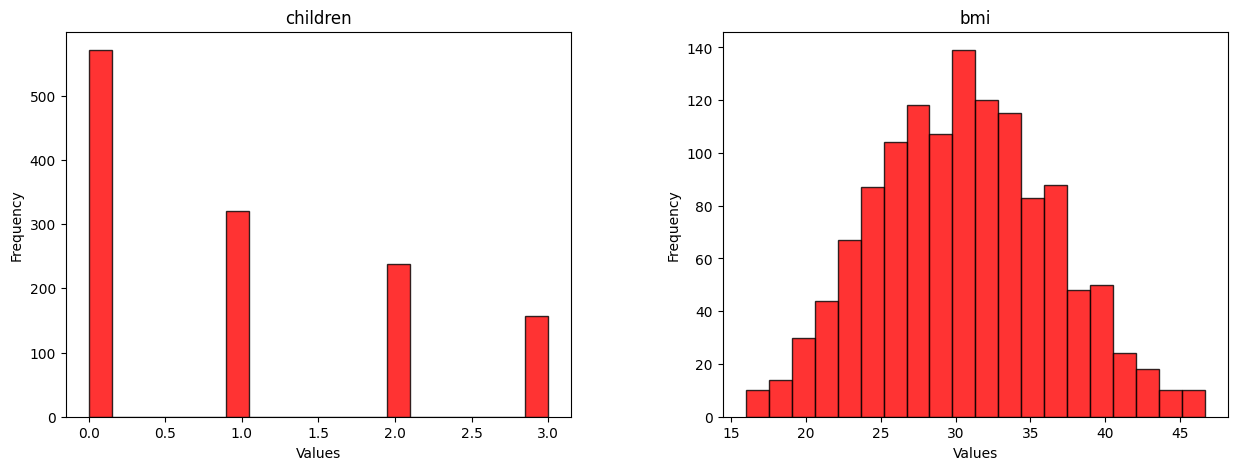

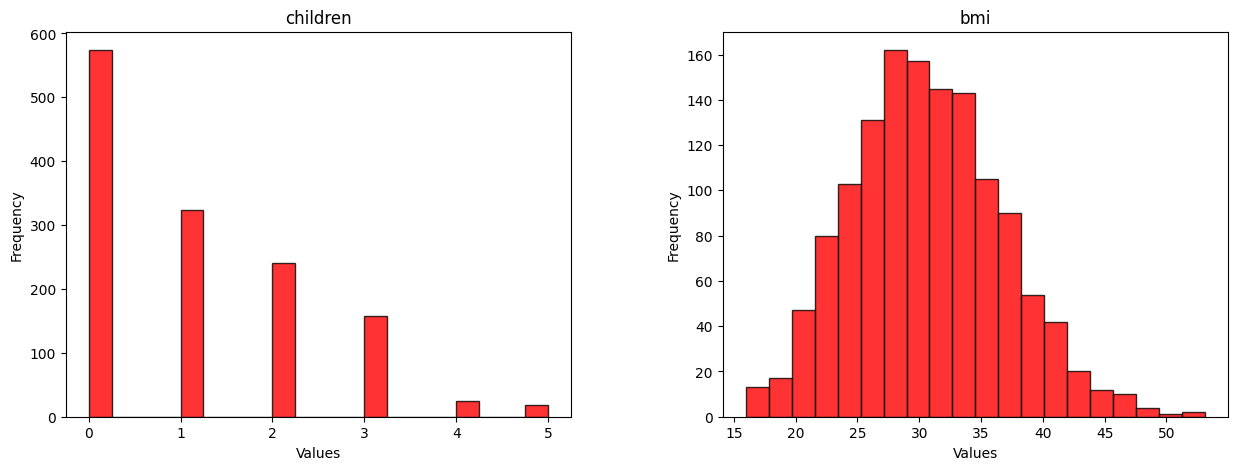

In [17]:
print_style("new dataframe after removing outliers")
visualize(df_removed_outliers, ["children","bmi"], "hist", (15,5), 2)
print_style("new dataframe before removing outliers")
visualize(df, ["children","bmi"], "hist", (15,5), 2)

#### Mean Imputation Method

In [18]:
#Numerical - bim
mean_bmi = df["bmi"].mean() #30.66345175766642
df_mean_imputation = df.copy()
df_mean_imputation.loc[(df_mean_imputation["bmi"] < inner_fence[0]) | (df_mean_imputation["bmi"] > inner_fence[1]), "bmi"] = mean_bmi
#Categorical - children
mode_children = df_mean_imputation["children"].mode()
frequency = df_mean_imputation["children"].value_counts()
outliers_values = frequency[frequency < threshold].index
df_mean_imputation.loc[df_mean_imputation["children"].isin(outliers_values), "children"] = mode_children[0]

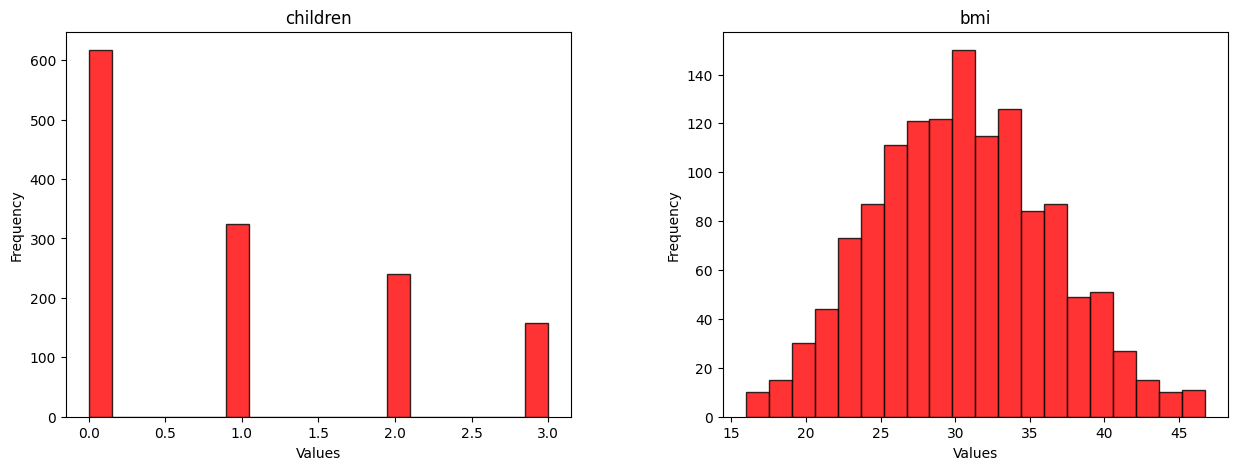

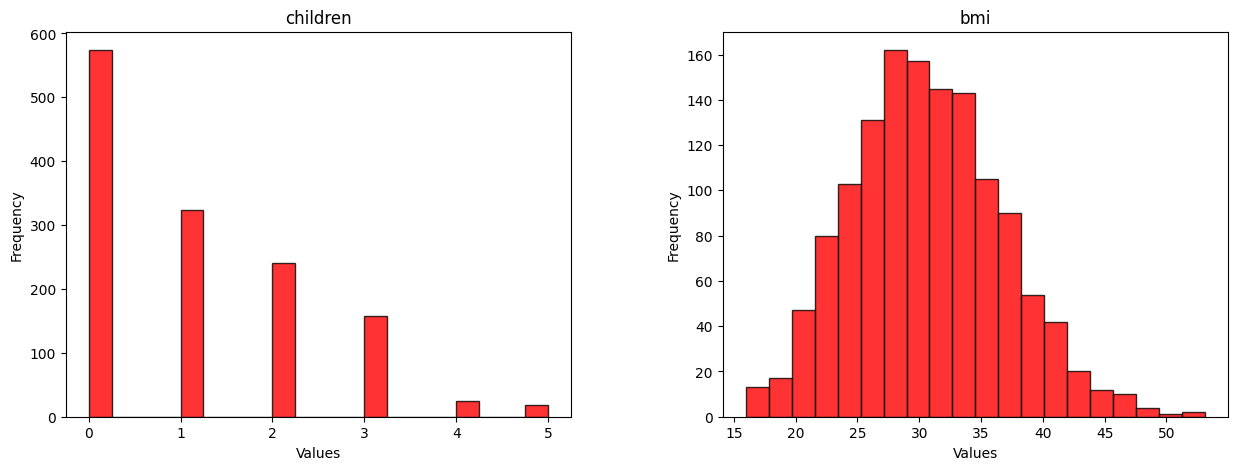

In [19]:
print_style("new dataframe after mean imputation method")
visualize(df_mean_imputation, ["children","bmi"], "hist", (15,5), 2)
print_style("new dataframe before mean imputation method")
visualize(df, ["children","bmi"], "hist", (15,5), 2)

#### Median Imputation Method

In [20]:
#Numerical - bim
median_bmi = df["bmi"].median() #30.4
df_median_imputation = df.copy()
df_median_imputation.loc[(df_median_imputation["bmi"] < inner_fence[0]) | (df_median_imputation["bmi"] > inner_fence[1]), "bmi"] = median_bmi
#Categorical - children
mode_children = df_median_imputation["children"].mode()
frequency = df_median_imputation["children"].value_counts()
outliers_values = frequency[frequency < threshold].index
df_median_imputation.loc[df_median_imputation["children"].isin(outliers_values), "children"] = mode_children[0]

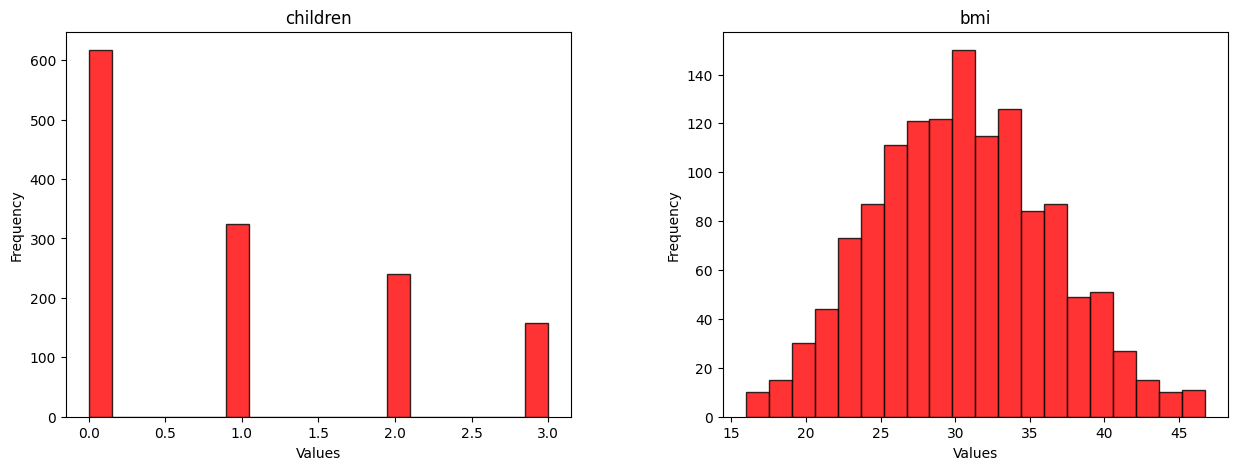

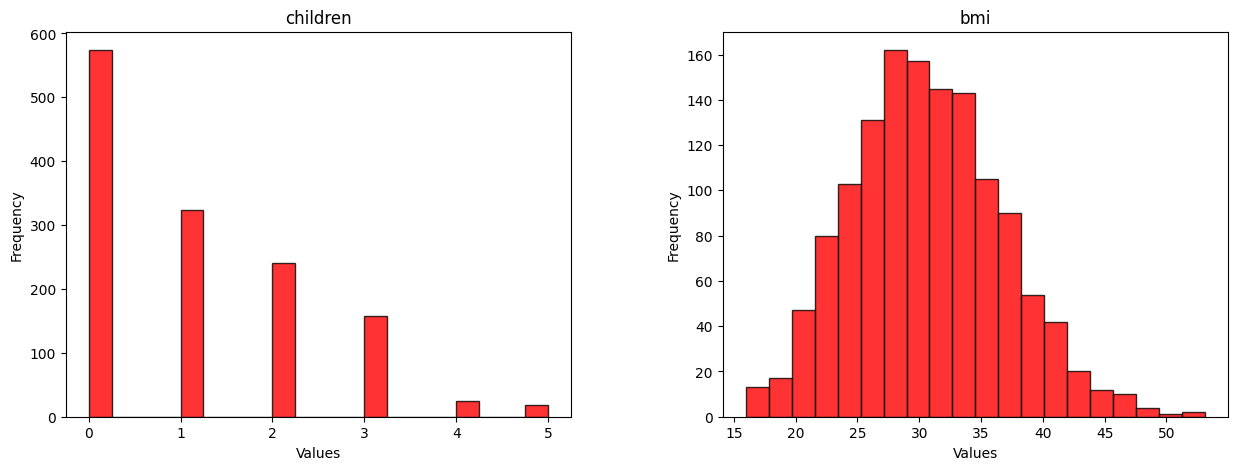

In [21]:
print_style("new dataframe after median imputation method")
visualize(df_median_imputation, ["children","bmi"], "hist", (15,5), 2)
print_style("new dataframe before median imputation method")
visualize(df, ["children","bmi"], "hist", (15,5), 2)

#### Outlier Handling Report
Since the mean and the median are similar we don't notice much of a difference between the mean and median method.
However, there is some difference between these two and the removal method.
We have 9 numerical outliers. Since the mean can be influenced by those outliers along with having a very close values between the mean and the median <b>Maybe the median dataset can give better predictions</b>. Especially that the data is positively skewed in most of its features.

## 1.4. Encode the Ordinal Features with Ordinal Encoding

In [22]:
#Yes - 1
#No - 0
df_original_encoded = encode_ordinal(df, "smoker")
df_removed_outliers_encoded = encode_ordinal(df_removed_outliers, "smoker")
df_mean_encoded = encode_ordinal(df_mean_imputation, "smoker")
df_median_encoded = encode_ordinal(df_median_imputation, "smoker")

## 1.5. Manually shuffle the dataset and split it into training (70%) and testing (30%) sets.

In [23]:
# your code here
#Splits a dataset into a training and a testing dataset
#dataframe: is the dataframe to be split
#train_percentage: the percentage of training data from the original dataset
#test_percentage: the percentage of testing data from the original dataset
#return: returns the new dataframe
def custom_train_test_split(dataframe, train_percentage, test_percentage):
    if(train_percentage + test_percentage > 1 or train_percentage < 0 or test_percentage < 0):
        print("Error!")
        return (0,0,0,0)
    df_shuffled = dataframe.sample(frac=1, random_state=1)
    train_nbr_rows = int(df_shuffled.shape[0] * train_percentage)
    test_nbr_rows = df_shuffled.shape[0] - train_nbr_rows
    train_dataframe = df_shuffled.iloc[:train_nbr_rows, :]
    test_dataframe = df_shuffled.iloc[train_nbr_rows:train_nbr_rows + test_nbr_rows, :] #Logic made like in case train_percentage + test_percentage < 1 like for validation
    #return x_train, x_test, y_train, y_test
    return (train_dataframe.iloc[:,:-1], test_dataframe.iloc[:,:-1], train_dataframe.iloc[:,-1], test_dataframe.iloc[:,-1])


x_train_original, x_test_original, y_train_original, y_test_original = custom_train_test_split(df_original_encoded, 0.7, 0.3)
x_train_removed, x_test_removed, y_train_removed, y_test_removed = custom_train_test_split(df_removed_outliers_encoded, 0.7, 0.3)
x_train_mean, x_test_mean, y_train_mean, y_test_mean = custom_train_test_split(df_mean_encoded, 0.7, 0.3)
x_train_median, x_test_median, y_train_median, y_test_median = custom_train_test_split(df_median_encoded, 0.7, 0.3)

# **PART- 2: REGRESSION**
* Target value: charges
* Predictors: The rest

* ***You can use scikit-learn***




## 2.1. kNN Regression
* For each version of the dataset (original, outlier-removed, mean-imputed, median-imputed), execute the following steps:
    * Split the data into train and test sets
    * Create an instance of kNN with a number of neighbors between 1-30, then fit kNN regression model to train data.
    * Predict the test set and calculate the MSE value for each k.
    * Plot the MSE vs k curve to decide on the optimal k.
    * Report the R-squared value for the optimal k.
* Compare the MSE values for each dataset and comment on the results. Which dataset gives the best result? Why do you think that is?


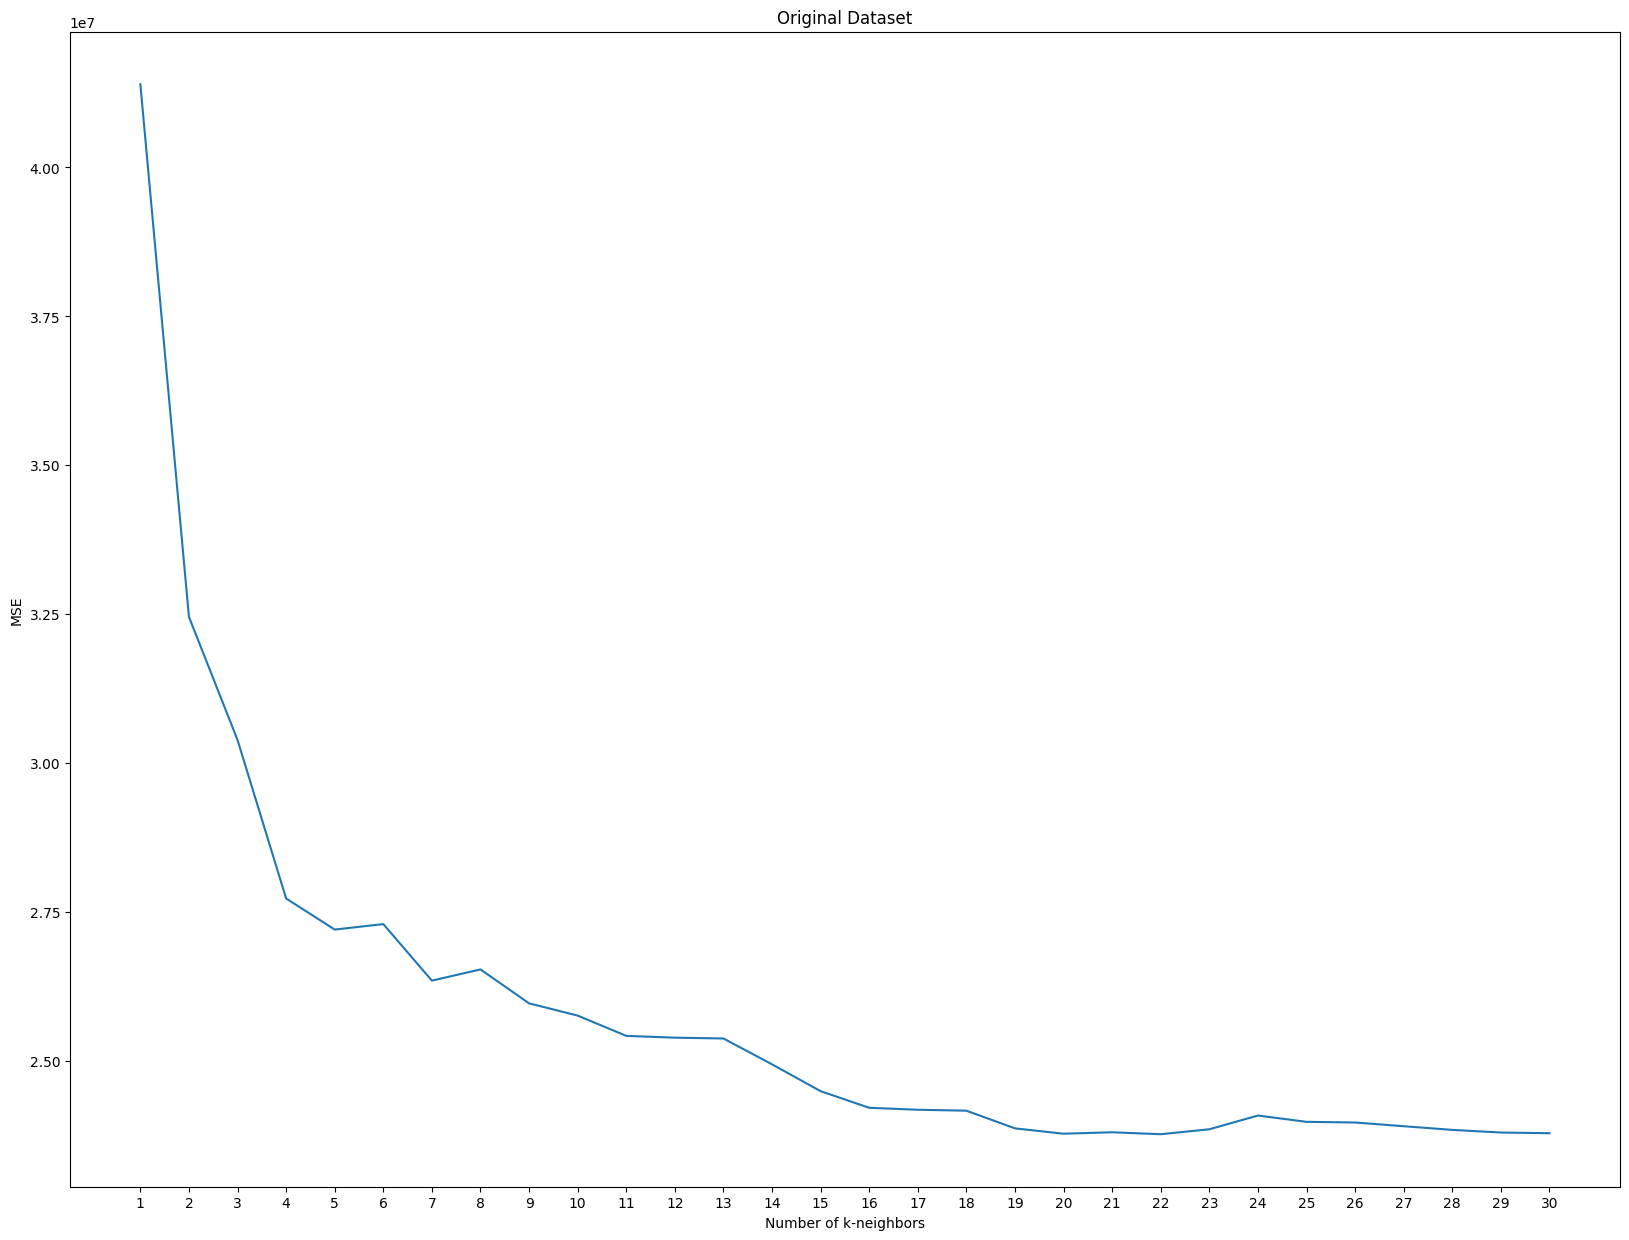

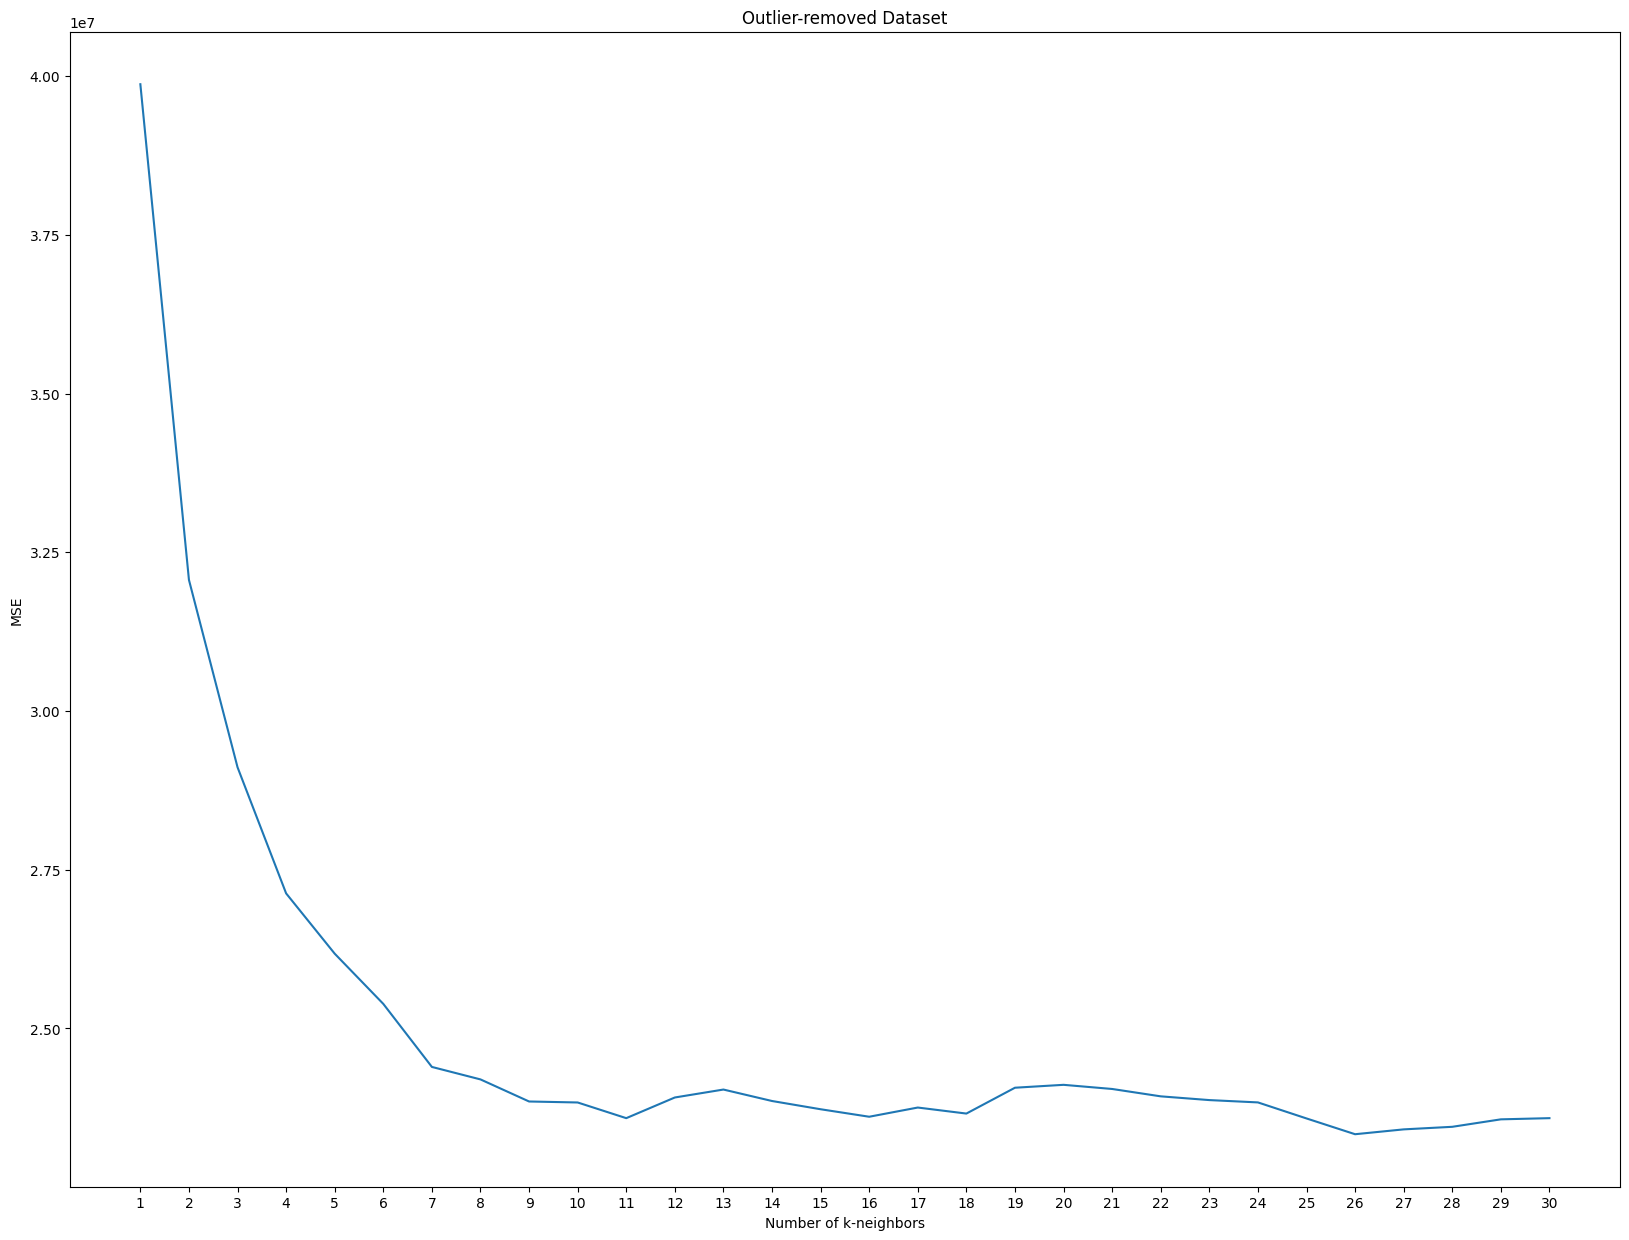

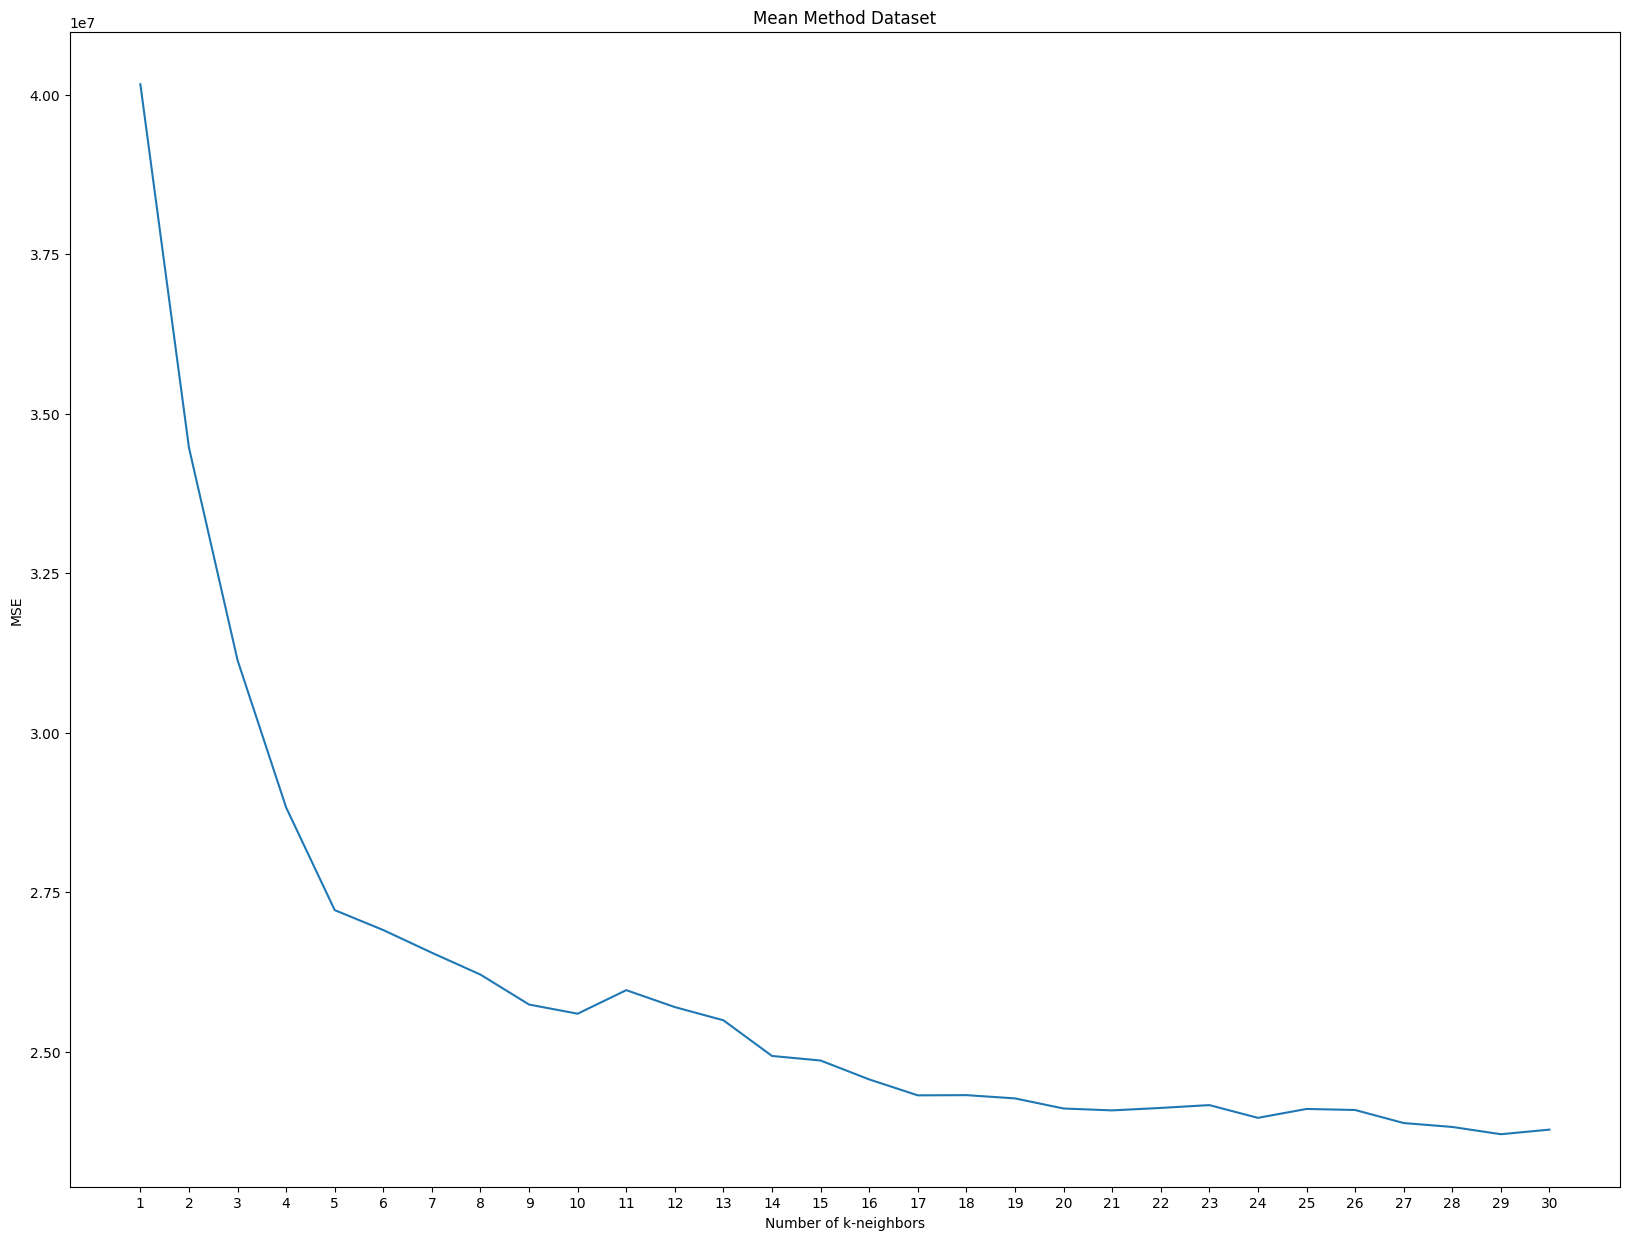

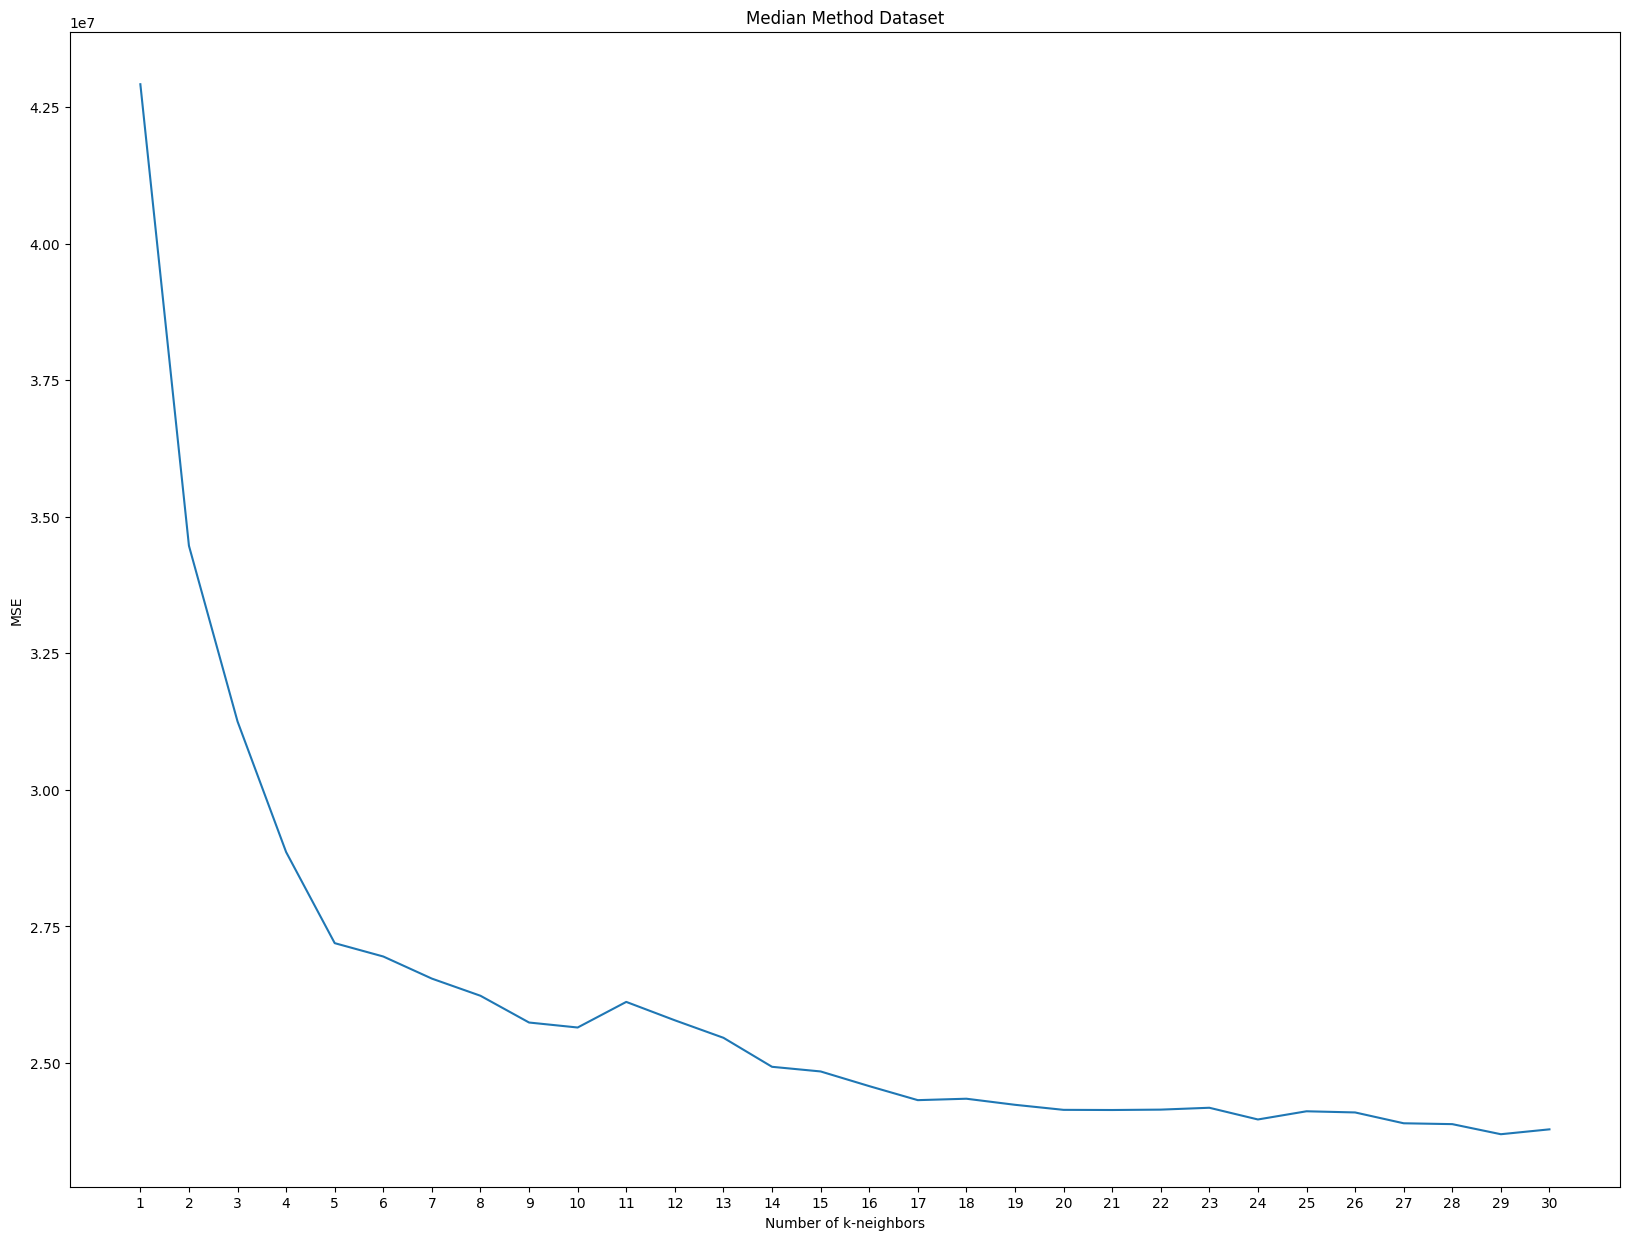

In [24]:
# outlier-removed
def knn_model(x_train, x_test, y_train, y_test, k_numbers):
    scale = StandardScaler()
    X_train_scaled = scale.fit_transform(x_train)
    X_test_scaled = scale.transform(x_test)
    mse_values = []
    y_pred = 0;
    for k in k_numbers:
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(X_train_scaled, y_train)
        y_pred = knn.predict(X_test_scaled)
        mse_values.append(mean_squared_error(y_test, y_pred))
    return (y_pred, mse_values)
    
def knn_mse_plot(x_train, x_test, y_train, y_test, title):
    k_numbers = range(1,31)
    y_pred, mse_values = knn_model(x_train, x_test, y_train, y_test, k_numbers)
    plt.figure(figsize=(20,15))
    plt.plot(k_numbers, mse_values)
    plt.title(title)
    plt.xticks(k_numbers)
    plt.xlabel("Number of k-neighbors")
    plt.ylabel("MSE")
    plt.show()
knn_mse_plot(x_train_original, x_test_original, y_train_original, y_test_original, "Original Dataset") #original
knn_mse_plot(x_train_removed, x_test_removed, y_train_removed, y_test_removed, "Outlier-removed Dataset") #outlier_removed
knn_mse_plot(x_train_mean, x_test_mean, y_train_mean, y_test_mean, "Mean Method Dataset") #mean
knn_mse_plot(x_train_median, x_test_median, y_train_median, y_test_median, "Median Method Dataset") #median

#### Findings Analysis Report - The Elbow Method:
According to the elbow method:
- The original dataset has two candidates: 4 or 5. A better candidiate would be 4 for this.
- The Outlier-removed dataset has two candidates: 5 or 8. A better candidate would be 5 for this.
- The mean method dataset has an obvious optimal k number: 4
- The median method dataset also has an obvious optimak k number: 4

#### R-Squared & MSE:

In [25]:
#original dataset
k_original_optimal = 4
y_pred_original, mse_values_original = knn_model(x_train_original, x_test_original, y_train_original, y_test_original, range(k_original_optimal, k_original_optimal + 1))
r_squared_original = r_squared(y_test_original, y_pred_original)
#outlier-removed dataset
k_optimal_removed = 5
y_pred_removed, mse_values_removed = knn_model(x_train_removed, x_test_removed, y_train_removed, y_test_removed, range(k_optimal_removed, k_optimal_removed + 1))
r_squared_outlier_removed = r_squared(y_test_removed, y_pred_removed)
#mean method dataset
k_optimal_mean = 4
y_pred_mean, mse_values_mean = knn_model(x_train_mean, x_test_mean, y_train_mean, y_test_mean, range(k_optimal_mean, k_optimal_mean + 1))
r_squared_outlier_mean = r_squared(y_test_mean, y_pred_mean)
#median method dataset
k_optimal_median = 4
y_pred_median, mse_values_median = knn_model(x_train_median, x_test_median, y_train_median, y_test_median, range(k_optimal_median, k_optimal_median + 1))
r_squared_outlier_median = r_squared(y_test_median, y_pred_median)

print_style("R-Squared")
print("kNN Original Dataset R²: ", r_squared_original)
print("kNN Outlier-Removed Dataset R²: ", r_squared_outlier_removed)
print("kNN Mean Method Dataset R²: ", r_squared_outlier_mean)
print("kNN Median Method Dataset R²: ", r_squared_outlier_median)
print_style("MSE")
print("kNN Original Dataset MSE: ", mse_values_original[0])
print("kNN Outlier-Removed Dataset MSE: ", mse_values_removed[0])
print("kNN Mean Method Dataset MSE: ", mse_values_mean[0])
print("kNN Median Method Dataset MSE: ", mse_values_median[0])

kNN Original Dataset R²:  0.8224759849998939
kNN Outlier-Removed Dataset R²:  0.841562133612179
kNN Mean Method Dataset R²:  0.8154456246320804
kNN Median Method Dataset R²:  0.815235322293025


kNN Original Dataset MSE:  27729868.33364738
kNN Outlier-Removed Dataset MSE:  26178065.465212826
kNN Mean Method Dataset MSE:  28828035.06527209
kNN Median Method Dataset MSE:  28860885.021782257


#### kNN MSE Comparison
We will use the original dataset as a reference point for comparsion.
- With the outliers removed we notice a decrease of 5.6% percent of the MSE from the original dataset. kNN performed better with the outliers removed.
- When we applied mean imputation we noticed an increase of 3.96% percent in the MSE score which suggests a worse performance. This can be explained by considering the mean value introduced to the outliers as bias.
- We see an increase of 4.07% percent in the MSE score for the median imputated dataset. This also suggests a worse performence which can be explained by considering the median value introduced to the outliers as bias.

As a result, the best dataset was the outlier-removed dataset. Which can be logical due to bias as explained before or maybe didn't capture a lot of variance by introducing the mean or the median which were very close.

## 2.2. Linear Regression
* For each version of the dataset (original, outlier removal, mean imputation, median imputation), do the following steps:
    * Split the data into train and test sets
    * Fit a linear regression model to train data.
    * Predict the test set and calculate the MSE value.

In [26]:
# your code here
#Data already split
#Scaling is not important in linear regression
def linear_model(x_train, x_test, y_train, y_test):
    linear = LinearRegression()
    linear.fit(x_train, y_train)
    y_pred = linear.predict(x_test)
    return (y_pred, mean_squared_error(y_test, y_pred))

#Original
y_pred_original, mse_original = linear_model(x_train_original, x_test_original, y_train_original, y_test_original)
print("Linear Regression Original MSE: ", mse_original)
#Outlier-Removed
y_pred_removed, mse_median = linear_model(x_train_removed, x_test_removed, y_train_removed, y_test_removed)
print("Linear Regression Outlier-Removed MSE:", mse_median)
#Median
y_pred_median, mse_median = linear_model(x_train_median, x_test_median, y_train_median, y_test_median)
print("Linear Regression Median MSE: ", mse_median)
#Outlier-Removed
y_pred_mean, mse_mean = linear_model(x_train_mean, x_test_mean, y_train_mean, y_test_mean)
print("Linear Regression Mean MSE: ", mse_mean)

Linear Regression Original MSE:  36320552.454572186
Linear Regression Outlier-Removed MSE: 34282564.567396306
Linear Regression Median MSE:  35924764.292666696
Linear Regression Mean MSE:  35928021.03259379


## 2.3. Compare the Regression Methods

* Compare and contrast the performance of kNN and Linear Regression models across the different dataset versions (those attained in 1.3.).

* Discuss the strengths and limitations of each model based on your results

In [27]:
# Linear Regression R²
print_style("kNN Regression")
print("Original R²: ", r_squared_original)
print("Outlier-Removed R²: ", r_squared_outlier_removed)
print("Mean Method R²: ", r_squared_outlier_mean)
print("Median Method R²: ", r_squared_outlier_median)
print_style("Linear Regression")
print("Original R²: ", r_squared(y_test_original, y_pred_original))
print("Outlier-Removed R²: ", r_squared(y_test_removed, y_pred_removed))
print("Mean R²: ", r_squared(y_test_mean, y_pred_mean))
print("Median R²: ", r_squared(y_test_median, y_pred_median))

Original R²:  0.8224759849998939
Outlier-Removed R²:  0.841562133612179
Mean Method R²:  0.8154456246320804
Median Method R²:  0.815235322293025


Original R²:  0.7674792313768797
Outlier-Removed R²:  0.7925111620039712
Mean R²:  0.7699921807066373
Median R²:  0.7700130300500497


#### Model Comparsion Report:
kNN Regression has higher R² squared values making it more promising for this dataset.
- kNN Regression is a great model to capture complex or non-liner relationships and patterns between the features and the target variables. It is more data dependent than the linear model as it does not assume or create any linear mathematical formulas for predictions. During the data preprocessing phase, despite noticing some features such as age as having kind of a linear relationship with the target variable, non-linearlity was more dominated. However, it is worth saying that kNN was sensitive to unecessary information such as the outliers. We notice a small increase from 0.822 to 0.842 for the original dataset and outlier-removed dataset respectively. As anticipated before, there wasn't a big difference in the R² for the mean and median method as they were very close. But there again a difference between them and Outlier-Removed method: from 0.842 to 0.815. This validates the point that kNN is sensitive to any difference in data points. Because of the low outliers we had we weren't able to have a drastic difference of course. <br />
=> kNN performed very well for this dataset.
- Linear regression performed well for this dataset but not as good as kNN. Linear regression assumed a linear relationship between the indeseripendent variables and the target variable. The relationship is more complex than that which resulted in the lower performance of this model. This is called underfitting, it's not too serious in our assignment. We also notice that the Linear regression is susceptible to outliers as we witness an increase from 0.767 to 0.793 for the original dataset R² score and the Outlier-Removed dataset R² score respecitvely.<br />
=> Linear regression performed well but worse than kNN <br />
=> Testing is one of the primordial tools to achieve great results for modeling.